# 10. Seq2seq와 Attention
---
언어 모델이 발전해 온 과정에 대해 개략적으로 공부하고, NLP의 큰 흐름 중 하나인 Sequence to Sequence(Seq2seq)에 대해 공부합니다. 이를 발전시키기 위한 기법이자 지금은 없어선 안 될 중요한 메커니즘인 Attention에 대해서도 살펴볼 거고요. 부디 즐거운 시간이 되시길 바랍니다!

10-1. 들어가며<br>
10-2. 우리가 만드는 언어 모델<br>
10-3. Sequence to Sequence 문제<br>
10-4. Sequence to Sequence 구현<br>
10-5. Attention! (1) Bahdanau Attention<br>
10-6. Attention! (2) Luong Attention<br>
10-7. 트랜스포머로 가기 전 징검다리?<br>
10-8. 마무리하며

### Keyword
1. 언어모델의 발전
    1. 통계적 언어 모델(SLM) - 고정길이 단어셋 사용, sparsity problem
    2. 신경망 언어 모델(NNLM) - 고정길이 단어셋 사용
    3. 신경망 언어 모델(RNN) - vanishing gradient, 문장번역 x
    4. RNN Encoder-Decoder - context vector 등장
    5. Seq2seq - 위에꺼 개선, but context vector길이가 고정 ~ 정보손실
    6. Attention - 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축
        1. Bahadanau : 첫 attention 구조
        2. Loung
            - local attention ~ aligned position
            - input feeding
    7. GNMT : attention을 활용한 seq2seq 모델
        - 8개 층을 쌓은 Encoder-Decoder 구조와 Residual Connection
    8. Transformer : Multi-Head Attention 개념 도입
2. Seq2seq
    1. metric : BLEU, perplexity
    2. 구현 : LSTM Encoder-Decoder
3. Attention
    1. Bahdanau attenttion
    2. Loung attention
4. GNMT
    


## 10-1. 들어가며
---

### 학습 목표

- 언어 모델이 발전해 온 과정을 개략적으로 설명할 수 있다.
- 기존 RNN 기법이 번역에서 보인 한계를 파악하고, 이를 개선한 `Seq2seq`를 이해할 수 있다.
- Seq2seq를 발전시킨 `Attention`에 대해 설명할 수 있다.

## 10-2. 우리가 만드는 언어 모델
---

- 언어 모델(Language Model) : 단어의 시퀀스를 보고 다음 단어에 **확률을 할당** 하는 모델
    - n-1개의 단어 시퀀스 w1, w2, ... wn-1 가 주어졌을 때, n번째 단어 wn으로 무엇이 올 지 예측하는 확률 모델로 표현
    - 파라미터 θ로 모델링하는 언어 모델을 다음과 같이 표현
    - $P(w_n|w_1,...,w_{n-1};θ)$


- 언어 모델의 발전
    1. [통계적 언어 모델](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/) (Statistical Language Model)
    2. [신경망 언어 모델](https://wikidocs.net/45609) (Neural Network Language Model, NNLM)
    3. 순환 신경망(Recurrent Neural Network, 이하 RNN)을 활용한 언어 모델
    

- 희소문제(sparsity problem): 모델이 충분한 데이터를 관측하지 못하면 언어를 정확히 모델링 할 수 없는 문제를 말한다. <u>한 번도 관측하지 못한</u> 데이터에 대해선 **0에 확률을 부여**한다는 것에서 문제가 발생

## 10-3. Sequence to Sequence 문제
---

- 통계적 언어 모델 : 기존 n-gram 언어모델
>(1) 𝑃(𝑇𝑜𝑑𝑎𝑦 𝑖𝑠 𝑊𝑒𝑑𝑛𝑒𝑠𝑑𝑎𝑦)=0.001<br>
>(2) 𝑃(𝑇𝑜𝑑𝑎𝑦 𝑊𝑒𝑑𝑛𝑒𝑠𝑑𝑎𝑦 𝑖𝑠)=0.0000000001<br>
>**단점** : 충분한 데이터가 없다면 범용적인 모델을 구축하기 어려움<br>
>이유 : 한 번도 본 적 없는(학습 데이터에 존재하지 않는) 단어/문장에 대해서는 확률을 부여할 수 없다.<br>
> 따라서 언어 모델이 아우르는 범위를 넓히기 위해 다양한 단어를 포함하는 데이터가 필요하다. <br>
>(양까지 충분하다면 정의하는 확률이 일반적이므로 더욱 좋다.)

- NNLM : 희소문제 해결
> one-hot vector(input) <br>
>-> lookup table ~ embedding vector ~ concatenate -> projection layer(linear) <br>
>-> hidden layer(nonlinear) ~ softmax ~><br>
>-> output layer ~ pred --cross-entropy-- label ~ 'loss' ~ training <br>
> **장점** : 본적없는 단어/문장도 embedding을 통해 예측 가능<br>
> **단점** : 여전히 고정된 길이의 단어셋 사용

- RNN : 
> **장점** : 전체 문장을 볼 수 있지만, <br>
> **한계1** : 정보가 길어질수록 Vanishing Gradient 문제 -> LSTM으로 개선 <br>
> **한계2** : 문장 생성..?(**다음 문장 확률 예측**이 맞는듯)에는 적합한데 번역에는 사용하기 어려움(**순서 정보(어순)**가 바뀌기 때문 + 입력길이와 번역길이가 다를 수 있음)
> ~~ 번역을 위해선 문장을 다 읽고 번역하는 ~ 문장 전체를 본 뒤에 생성 -> seq2seq(google)

- [Sequence to sequence](https://reniew.github.io/35/):
> 논문: [Sequence to Sequence Learning with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)<br>
>번역에 있어서는 문장을 다 읽고 번역하는, 즉 문장 전체를 보고 나서 생성하는 구조가 필요했습니다. 이에 2014년, 구글이 Sequence to Sequence(Seq2Seq) 구조를 제안<br>
>https://wikidocs.net/24996
>
> - **등장 배경** : 기존 언어모델은 번역에 사용하기 어려움 -> 단어의 순서정보가아닌 **"문장 전체에 해당하는 정보"**가 필요
> - **기본 구조** : **Encoding ~ `context` ~ decoding**
> - **"최초의 Neural machine translation 모델"**


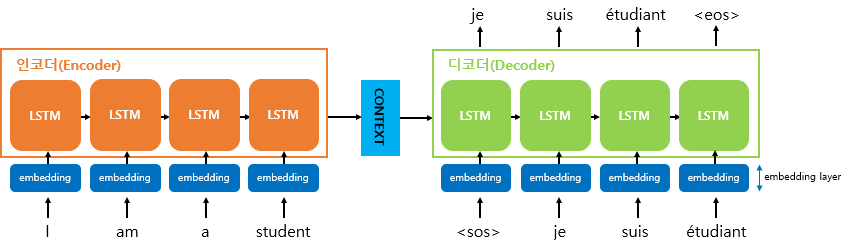
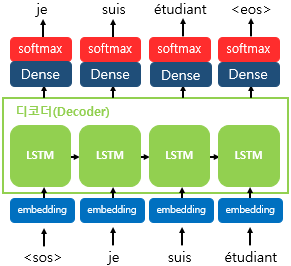

- https://reniew.github.io/35/


### Seq2seq

개념 제시 논문 
1. [Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
    - 여기서 처음으로 번역을 위한 RNN encoder-decoder 구조 제시 + GRU소개
    

2. [Sequence to Sequence with Neural Network](https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf)
    - 구글에서 1번 논문 참고해서 다듬어서 seq2seq발표
    
- 기본 구조 : 
    - RNN의 encoder로 가변길이 sequence를 고정된 sequence vector로 변환, decoder에 사용. 
    - decoder를 통해 나온 문장과 실제 reference문장을 비교, 
    - loss를 구해 문장 확률분포의 조건부 확률 $p(y_1, ..., y_T'|x_1, ...,x_T)$를 최대화 (max theta)


- Seq2seq의 조건부확률 :<br>
> $p(y_1, ..., y_T'|x_1, ...,x_T) = \prod_{t=1}^{T'}p(y_t|v,y_1, ...,y_{t-1})$<br>
> - $x$: Input Sequence<br>
> - $y$: Output Sequence<br>
> - $v$: 인코더의 입력 x에 대한 고정된 크기의 Representation Vector 아웃풋으로서, 디코더의 입력으로 사용됨

- 특징 
    - simpleRNN 대신 LSTM사용
    - 입력 sequence를 역순으로 입력 ~ establish communication
        - BLEU 상승, perplexity(PPL) 감소

## 10-4. Sequence to Sequence 구현
---

일단은 데이터를 직접 다루기보다는 차원 수를 확인하는 실습

1) LSTM Encoder<br>
2) LSTM Decoder

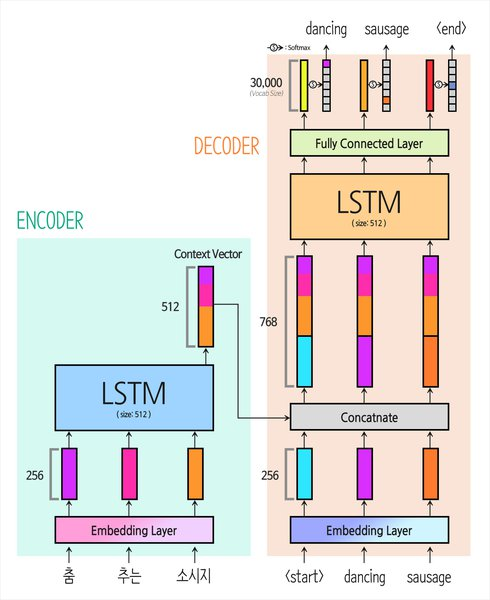

In [3]:
# 매개변수 설정
vocab_size = 30000 # 단어의 수
emb_size = 256     # embedding vector크기
lstm_size = 512    # lstm units
batch_size = 1
sample_seq_len = 3

### 1) LSTM Encoder

In [4]:
import tensorflow as tf


class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(enc_units) # return_sequences 매개변수를 기본값 False로 전달

  def call(self, x):
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    output = self.lstm(x)
    print("LSTM Layer의 Output Shape:", output.shape)

    return output # context vector

Embedding 레이어를 
- 단어 사이즈와 
- Embedding 차원에 대해 선언을 한 후, 

논문에서 소개한 대로 tf.keras.layers.LSTM(enc_units)으로 LSTM을 정의합니다. 

TensorFlow 속 LSTM 모듈의 
- 기본 반환 값은 최종 State 값

이므로 
- return_sequences 나 
- return_state 값은 따로 조정하지 않습니다 (기본: False).

즉, 우리가 정의해 준 
- Encoder 클래스의 반환 값이 
- 곧 컨텍스트 벡터(Context Vector) 가 되는 겁니다. 

추가적인 옵션이 궁금하시다면 아래의 TensorFlow LSTM 공식 문서를 참조하시면 좋습니다.

In [5]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [6]:
# 인코더 모양 확인
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input)    # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State값

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
LSTM Layer의 Output Shape: (1, 512)


### 2) LSTM Decoder


In [7]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 유의!

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(dec_units,
                                     return_sequences=True) # return_sequences 매개변수를 True로 설정
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.softmax = tf.keras.layers.Softmax(axis=-1)

  def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                          repeats=x.shape[1], axis=1)
    x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
    print("Context Vector가 더해진 Shape:", x.shape)

    x = self.lstm(x)
    print("LSTM Layer의 Output Shape:", x.shape)

    output = self.fc(x)
    print("Decoder 최종 Output Shape:", output.shape)

    return self.softmax(output)

print("슝~")

슝~


Decoder가 매 스텝 생성하는 출력은 우리가 원하는 "번역 결과"에 해당

하므로 LSTM 레이어의 "return_sequences 변수를 True로 설정"하여 State 값이 아닌 Sequence 값을 출력으로 받습니다.

In [8]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [9]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
Context Vector가 더해진 Shape: (1, 3, 768)
LSTM Layer의 Output Shape: (1, 3, 512)
Decoder 최종 Output Shape: (1, 3, 30000)


## 10-5. Attention! (1) Bahdanau Attention
---
- Seq2seq 한계점 : context vector의 길이가 고정 -> 정보 손실 ~ 문장이 길어질수록 성능이 저하
- Seq2seq의 한계점 때문에 등장한 개념 : `Attenetion mechanism`



### Bahdanau Attention

- 원본 논문: [NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE](https://arxiv.org/pdf/1409.0473.pdf)
- 정리 글: [Attention mechanism in NLP. From seq2seq + attention to BERT](https://lovit.github.io/machine%20learning/2019/03/17/attention_in_nlp/)


- Bahdanau : seq2seq의 한계(context vector size고정)를 지적, attention 개념을 처음으로 제시, 2015
    - 고정된 context vector -> <u>긴 문장 해석의 성능이 떨어짐</u>. 짧은 문장에 비해.
    
 
- Bahdanau Attention : 
    - 기존방식(`seq2seq`) : context vector로 Encoder의 **최종 State 값**만을 사용 
    - 바다나우(`attention`) : **매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축**하는 **Attention 메커니즘** 제안


- Bahdanau Attention layer 구조
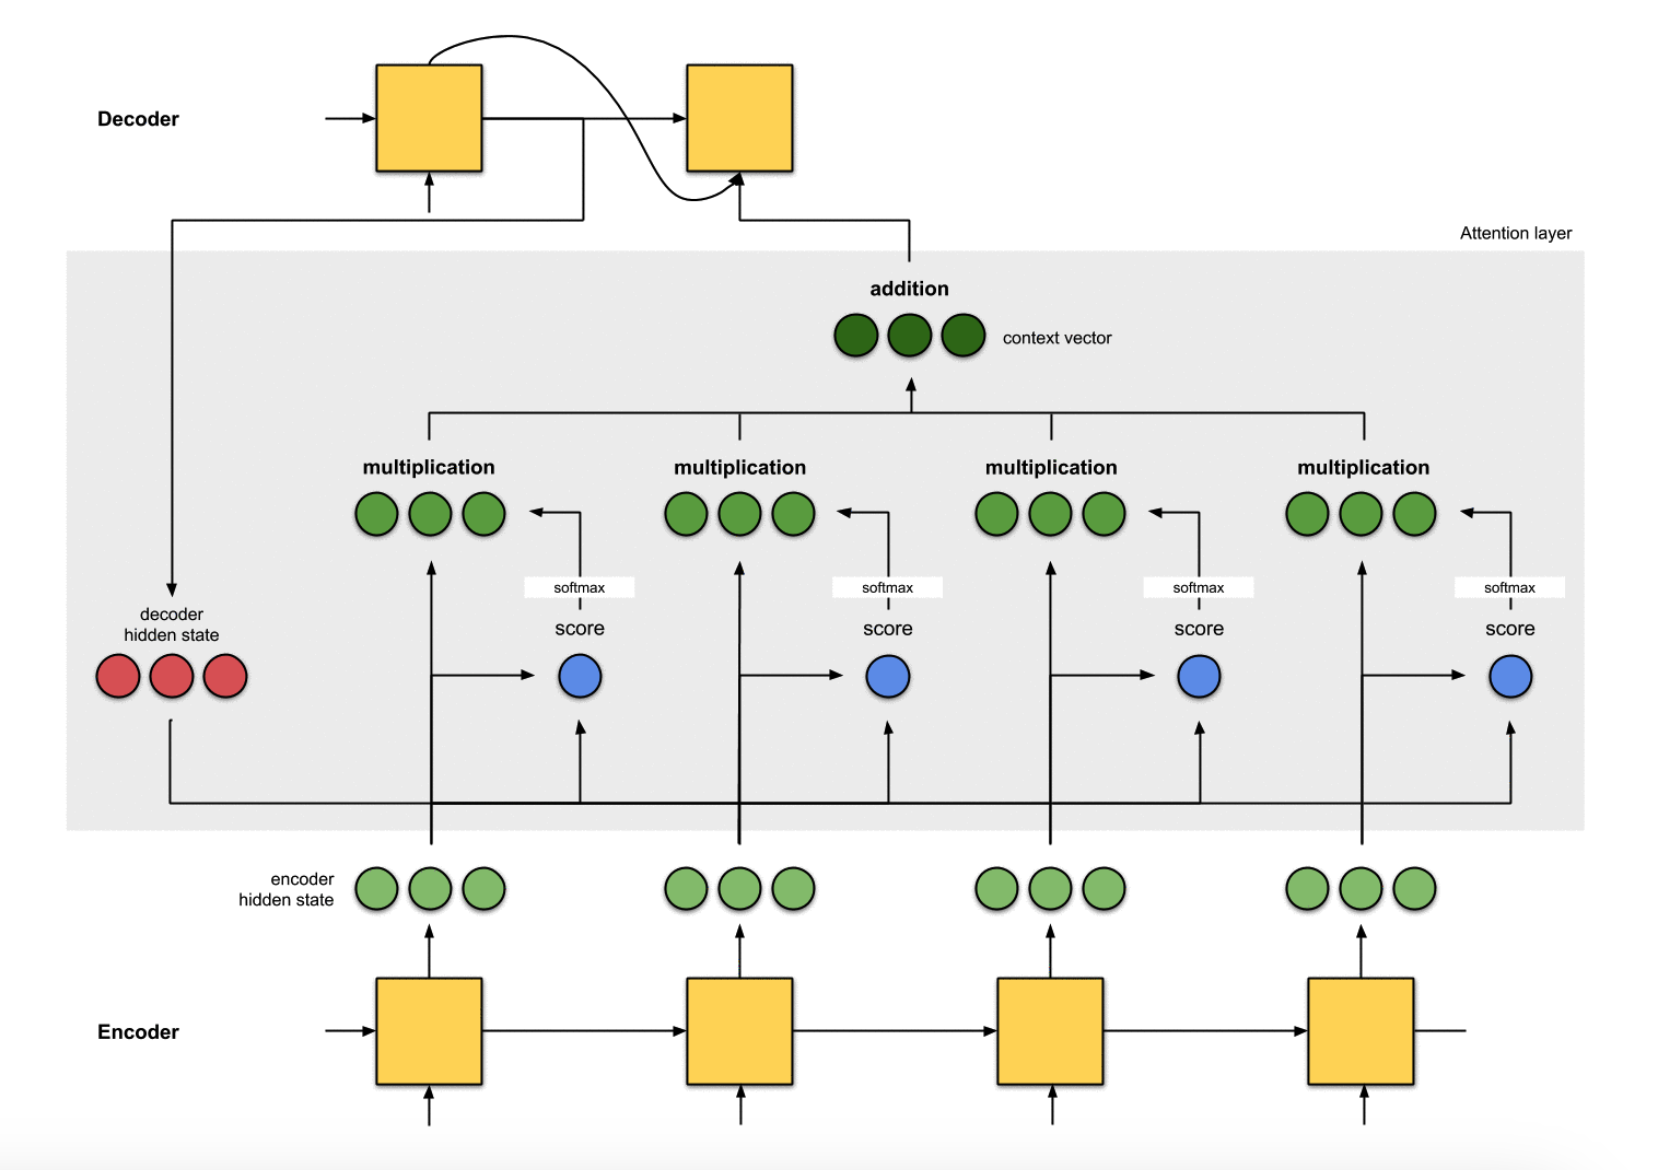

<!--
>Q. 블로그 저자의 사견에 따르면 모델의 성능 향상 외에 Attention을 활용할 수 있는 방법이 하나 있습니다. 부산물이라고 표현된 그 방법은 무엇인가요?<br>
A. Attention Map의 **시각화를 통해 모델의 안정성을 점검**할 수 있고, 모델이 의도와 다르게 작동될 경우 그 원인을 찾아내는 데에 이용될 수 있다.


>Q. Sequence Labeling과 Sequence to Sequence의 예시를 하나씩 적고, 두 Task의 차이점에 대해 간단히 설명해봅시다.<br>
A. 
>- Sequence Labeling: 품사 태깅
>- Sequence to Sequence: 번역
-->

### 수식

> Model ($y_i$) : $p(y_i|y_1,...,y_{i-1}, x) = g(y_{i-1}, s_i, c_i)$<br>
> : 주어진 $y_1$ ~ $y_{i-1}$과 input $X$로부터 예측 distribution $y_1$ 를 구하는 모델
> 이 모델은 
> - 이전 노드의 output인 : "$y_{i-1}$", 
> - 그로부터 구해진 decoder hidden state : "$s_i$", 
> - context vector : "$c_i$" 를 고려한 함수
>
> ---
>
>>$p(y_i|y_1,...,y_{i-1}, x) = g(y_{i-1}, s_i, c_i)$
>>- $s_i = f(s_{i-1}, y_{i-1}, c_i)$<br><br>
>>- $c_i = \Sigma_{j=1}^{T_x}a_{ij}h_j\\
\quad\quad\quad\;\; a_{ij} = softmax(e_{ij})\\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\; e_{ij} = v_a \times tanh(W_as_{i-1} + U_ah_j)$
>><br>
>>- $s_{i-1}$ : decoder hidden state ( $\times \;W_a$ )<br>
>>- $h_j\;\;\,$ : encoder hidden state ( $\times \;U_a$ )
> 
>---
> - $W_a, U_a, v_a$ : weight matrices 
> - $x$ : input
> - $y_{i-1}$ : 이전 디코더 ($y_{i-2}$)로부터 얻어진 값


- $X_j$의 hidden state : $h_j$
- $y_{i-1}$의 hidden state : $s_{i-1}$

- attention의 context vector $c_i$ : $c_i = \Sigma_{j=1}^{T_x}a_{ij}h_j$
- decoder의 $i$시점을 구하기 위한 alignment : $a_{ij}$



### seq2seq과 attn-seq2seq, 뭐가 다른가?
<!--
![image.png](attachment:image.png)
-->

> $c_i$ : 인코더가 X를 해석한 context $c_i$는 디코더의 포지션 $i$에 따라 다르게 표현(represent)되어야 한다.
> - 디코더의 매 state마다 context vector가 다름 -> 디코더의 입력 단어에 따라 다른 context로 표현


- seq2seq에서는 context vector가 고정, 
- attn- 에서는 디코더의 시각에 따라 context vector가 다르게 표현

디코더의 "현재 시점 $i$"에서, 인코더의 "어느 부분 $j$"가 중요한가? <br>
이 "어느 $j$"의 중요도는 softmax로 계산


이 <u>가중치</u>가 바로 `attention`인 것입니다.



### Bahdanau Attention 구현
---
- Bahdanau Attenteion ~ Baseline으로 많이 쓰임


구현 : 

In [47]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W_decoder = tf.keras.layers.Dense(units)
    self.W_encoder = tf.keras.layers.Dense(units)
    self.W_combine = tf.keras.layers.Dense(1)

  def call(self, H_encoder, H_decoder):
    '''
    H_encoder : tensor(1, 10, 512)
    H_decoder : tensor(1, 512)
    '''
    # "h_j"
    H_encoder = self.W_encoder(H_encoder)    # dense 거쳐서 512 -> 100으로 압축 (input -> hidden)(1, 10, 100)
    
    # "s_{i-1}""
    H_decoder = tf.expand_dims(H_decoder, 1) # 차원 늘려줘서 encoder랑 모양 맞춰줌
    H_decoder = self.W_decoder(H_decoder)    # dense 거쳐서 512 -> 100으로 압축 (input -> hidden)(1 ,1, 100)
    
    # "e_ij"(alignment) : E, D 두 hidden을 더해서 tanh 발라주고  1개의 값으로 압축 -> score : tensor(1, 10, 1)
    score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
    
    '''
    #print(H_decoder + H_encoder)             # (1, 10, 100) -> numpy라서 H_decoder값들이 H_encoder의 모든 column에 각각더해짐
    #print(tf.nn.tanh(H_decoder + H_encoder)) # (1, 10, 100). -> (-1 ~ 1)사이 값으로 바꿔줌
    #print(score)                             # (1, 10, 1) 100 -> 1로 압축(dense) -> 이 vector를 softmax로 돌려줌
    '''
    
    # "a_ij" 값
    attention_weights = tf.nn.softmax(score, axis=1)

    # "a_{ij}h_j"
    context_vector = attention_weights * H_encoder # H_decoder?
    # "c_i" = \Sigma_{j=1}^{T_x}a_{ij}h_j
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


# units : 100
W_size = 100 

# unit size(weight)를 100으로 설정
attention = BahdanauAttention(W_size)

# 랜덤 input값?
enc_state = tf.random.uniform((1, 10, 512)) # [512개의 원소를 가진 벡터] x 10
dec_state = tf.random.uniform((1, 512))     # [512개의 원소를 가진 벡터] x 1

# call : bahdanau attention에 맞는 크기 encoder, decoder 넣기 ( ~ dense layer ~ )
attn = attention(enc_state, dec_state)
print('context vector, c_i =\n\n', attn[0], '\n')
print('attention weight, a_{ij} =\n\n', attn[1])

context vector, c_i =

 tf.Tensor(
[[-0.3039488   0.6436833  -1.1275517   0.2784385   0.93010396  0.40302277
   0.54818374 -0.45930424  0.5443028  -0.22297221 -0.59724635 -0.9796355
   0.95968896 -0.5612146   0.07955213  0.56823134  0.00964489  0.3735466
  -0.485044    0.6430699  -0.53319377 -0.23837325 -0.07655311  0.2462714
   0.5136242   0.8673202   0.19076626  0.5380619   0.53328073 -1.1239108
  -0.0214018  -0.2661144   0.32291418  0.15986474 -0.13311538  0.15141039
  -0.49062878  0.9924191   0.20059144 -0.5086165   0.33683524  1.0876684
  -1.0589726  -0.64278585  1.1458883  -1.100867    0.6018453  -0.12036418
   0.6718835  -0.28878856 -0.33514154 -0.4454801   0.08262881  0.08514917
  -0.60689414 -0.01827822  1.0226281  -0.17838407  0.5356649   0.55486554
  -0.55909735 -0.20507284  1.404784    0.6713627  -0.1480208   0.03304441
  -0.17673719  0.5933775  -0.27030045  1.4723318  -0.60603344 -0.43679076
  -0.54184777  0.8018732   0.43479088 -0.20509683 -1.1420212   0.6068765
   0.7208

Encoder의 모든 스텝에 대한 Hidden State를 100차원의 벡터 공간으로 매핑 `(1, 10, 100)` 하고, : **dense(100)**<br>
Decoder의 현재 스텝에 대한 Hidden State 역시 100차원의 벡터 공간으로 매핑 `(1, 1, 100)`해 : **dense(100)**<br>
**두 State의 합으로 정의된 Score** `(1, 10, 1)` 를 구하는 모습입니다. : **dense(1)**

Softmax를 거쳐 나온 값은 `0-1` 사이의 값으로 "<u>각 단어가 차지하는 비중</u>"을 의미하겠죠? 

예시에서는 랜덤한 값을 사용했기 때문에 비중이 비슷비슷하지만 실제 단어로 적용시켜보면 **유사한 단어에 높은 비중을 할당**

In [51]:
'''
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W_decoder = tf.keras.layers.Dense(units)
    self.W_encoder = tf.keras.layers.Dense(units)
    self.W_combine = tf.keras.layers.Dense(1)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)
    
    # 1, 10, 512
    H_encoder = self.W_encoder(H_encoder) 
    print("[ W_encoder X H_encoder ] Shape:", H_encoder.shape)
    print("\n[ H_decoder ] Shape:", H_decoder.shape)
    
    # 
    H_decoder = tf.expand_dims(H_decoder, 1)
    
    H_decoder = self.W_decoder(H_decoder)
    print("[ W_decoder X H_decoder ] Shape:", H_decoder.shape)

    score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
    print("[ Score_alignment ] Shape:", score.shape)
    
    attention_weights = tf.nn.softmax(score, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    context_vector = attention_weights * H_encoder
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

W_size = 100

print("Hidden State를 {0}차원으로 Mapping\n".format(W_size))

attention = BahdanauAttention(W_size)

enc_state = tf.random.uniform((1, 10, 512)) # H_encoder size
dec_state = tf.random.uniform((1, 512)) # H_decoder size

_ = attention(enc_state, dec_state) # init으로 W_size 이미 받았고, W_size를 받은 클래스를 새로 어쩌구 해서 h shape 받음
'''
print('')

## 10-6. Attention! (2) Luong Attention
---
- Bahdanau attention에서의 개선
    1. decoder hidden state vector 구하는 방식 간소화 -> attention mechanism의 computation path 간소화
        - **context vector $c_t$ 를 구할 때 : $s_{t-1}$ 대신 $s_t$ 사용**
    2. `Local attention` 제시 (Alignment model)
        - (bahdanau ~ global attention)
    3. 다양한 score function 제시, 비교
    
    


- 몇가지 개념
    - local attention : hyperparameter $D$, Aligned Position $p_t$ 제시
    - input feeding : decoder input에 이전 alignment를 concat해서 정보 유지
    - score 간소화
        - 기존 : $Score_{concat}(s_t, h_j)\; =\; v_a^Ttanh(W_as_{t-1} + U_ah_j)$
        - 제시 : $Score_{general}(s_t, h_j) =\; s_t^TW_ah_j$

가리기
<!--
### 2b. Luong et. al (2015) [2]
Effective Approaches to Attention-based Neural Machine Translation의 저자들은 Bahdanau 등에서 아키텍처를 단순화하고 일반화하는 것을 강조했습니다. al. 방법은 다음과 같습니다.

1. 인코더는 2 스택 길이의 LSTM (short-term memory) 네트워크입니다. 디코더 또한 같은 아키텍처를 가지며, 디코더의 초기 hidden state는 마지막 인코더 hidden state입니다.
2. 그들이 실험 한 점수 함수는 (i) additive/concat, (ii) dot product, (iii) location-based, 그리고 (iv) general. 입니다.
3. 현재 디코더 시각 단계로부터의 출력과 현재 시각 단계로부터의 context 벡터 간의 연결은 현재 디코더 시각 단계의 최종 출력(분홍색)을 주기 위해 feed-forward neural network에 공급된다.

![image.png](attachment:image.png)
-->

### Luong attention 구현
---
Bahdanau의 Score 함수와는 다르게 하나의 Weight만을 사용하는 것이 특징입니다.<br> 
어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 
- Weight의 크기는 
    - 단어 Embedding 크기와 동일해야 연산이 가능<br>
    
합니다. 이 또한 번역에 적용해보고 성능을 비교해본다면 좋겠죠!

> genaral score 사용 :
>- $Score(s_t, h_j) =\; s_t^TW_ah_j$
>- $Score(H_{target}, H_{source}) = H_{target}^T \times W_{combine} \times H_{source}$

In [72]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    
    self.W_combine = tf.keras.layers.Dense(units) # units = 512

  def call(self, H_encoder, H_decoder):
    

    WH = self.W_combine(H_encoder)                                # (1, 10, 512)

    H_decoder = tf.expand_dims(H_decoder, 1)                      # (1, 512) -> (1, 1, 512) ~ transpose
    
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1])) # (1, 10, 1)
    
    attention_weights = tf.nn.softmax(alignment, axis=1)          # (1, 10, 1)
    
    attention_weights = tf.squeeze(attention_weights, axis=-1)    # (1, 10)
    
    context_vector = tf.matmul(attention_weights, H_encoder)      # (1, 1, 512)
    
    return context_vector, attention_weights

# input dim
emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim)) # TensorShape([1, 10, 512])
dec_state = tf.random.uniform((1, emb_dim))     # TensorShape([1, 512])

attn = attention(enc_state, dec_state)

'''
------------------output------------------
[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 512)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[1.8072571e-03]
  [7.4325637e-03]
  [8.7133510e-04]
  [1.1962978e-05]
  [1.9119400e-06]
  [1.0467304e-03]
  [9.7151774e-01]
  [1.0730951e-05]
  [9.9196295e-05]
  [1.7200546e-02]]]
------------------------------------------
'''
#print(attn[0]) # context vector    : (1, 1, 512)
print(attn[1]) # attention weights : (1, 10)

tf.Tensor(
[[3.8842765e-05 6.7067222e-04 2.5126114e-06 3.3704694e-03 9.9274796e-01
  1.2674766e-06 1.9425154e-03 6.3309071e-06 5.9169909e-04 6.2785315e-04]], shape=(1, 10), dtype=float32)


In [73]:
'''
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W_combine = tf.keras.layers.Dense(units)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    WH = self.W_combine(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", WH.shape)

    H_decoder = tf.expand_dims(H_decoder, 1)
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
    print("[ Score_alignment ] Shape:", alignment.shape)

    attention_weights = tf.nn.softmax(alignment, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    attention_weights = tf.squeeze(attention_weights, axis=-1)
    context_vector = tf.matmul(attention_weights, H_encoder)

    return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)
'''


print('')

## 10-7. 트랜스포머로 가기 전 징검다리? : GNMT
---
[Google's Neural Machine Translation System.](https://norman3.github.io/papers/docs/google_neural_machine_translation.html)
- GNMT : Attention(bahdanau)을 활용한 Seq2seq 모델


- Residual Connection을 사용했을 때의 이점
    - 정확도가 올라간다.
    - 학습 속도가 빨라진다.
    - Gradient Exploding / Vanishing 문제를 해결한다.
    
    
- GNMT에서 언급한 Copy Model
    -  한 번도 본 적 없는 단어에 대해서 `<UNK>` 토큰 처리를 하지 않고 단어를 그대로 복사하여 적당한 위치에 배치하는 모델


트랜스포머 모델은 `Multi-Head Attention`이라는 개념을 도입해
- **폭넓은 문맥을 파악**하게 하고, 
- **기존의 RNN 구조를 완전히 탈피하여 연산 속도 측면에서도 혁신적인 발전**

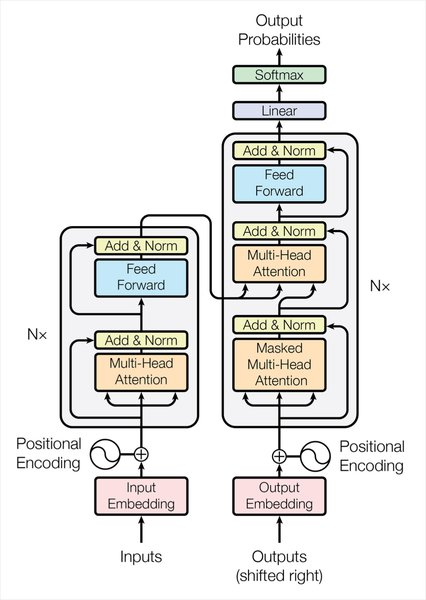


## 10-8. 마무리하며
---
이번 코스에서는 
1. 언어 모델의 흐름
2. Seq2seq
3. Attention 기법 두 가지 

- RNN 문제점 : 기울기 소실 문제, 번역에 사용하기는 어렵다는 문제


- Bahdanau, Luong Attention에 대해서 간단하게 정리<br><br>
    
    - Attention은 번역 모델에서 **입력 문장의 단어와 출력 문장의 단어 사이의 매핑 관계를 찾아내는 메커니즘**입니다. 
    - 이를 통해 **입력 문장의 모든 단어를 고려하면서 출력 문장의 각 단어를 예측**합니다. 
    - 그러나 문장이 길어질수록 Attention계산에 필요한 계산량이 많아지고, 희소성 문제 등 다양한 문제점이 발생합니다.<br><br>

    - Bahdanau Attention은 **전체 입력 문장에 대한 정보를 고려하여 출력을 생성**하는 반면, 
    - Luong Attention은 **현재 예측하려는 출력 단어와 관련된 입력 단어에만 집중**하여 출력을 생성합니다. 
    - 둘 중 어떤 어텐션을 사용할지는 데이터와 모델의 성능에 따라 선택할 수 있습니다.

### Keyword
1. 언어모델의 발전
    1. 통계적 언어 모델(SLM) - 고정길이 단어셋 사용, sparsity problem
    2. 신경망 언어 모델(NNLM) - 고정길이 단어셋 사용
    3. 신경망 언어 모델(RNN) - vanishing gradient, 문장번역 x
    4. RNN Encoder-Decoder - context vector 등장
    5. Seq2seq - 위에꺼 개선, but context vector길이가 고정 ~ 정보손실
    6. Attention - 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축
        1. Bahadanau : 첫 attention 구조
        2. Loung
            - local attention ~ aligned position
            - input feeding
    7. GNMT : attention을 활용한 seq2seq 모델
        - 8개 층을 쌓은 Encoder-Decoder 구조와 Residual Connection
    8. Transformer : Multi-Head Attention 개념 도입
2. Seq2seq
    1. metric : BLEU, perplexity
    2. 구현 : LSTM Encoder-Decoder
3. Attention
    1. Bahdanau attenttion
    2. Loung attention
4. GNMT
    
